In [ ]:
%%bash
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets list
 ! kaggle datasets download -d tawsifurrahman/covid19-radiography-database
 ! unzip covid19-radiography-database.zip


ref                                                    title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/covid-world-vaccination-progress                COVID-19 World Vaccination Progress                  36KB  2021-01-28 07:53:29           3275  
jorgesandoval/wind-power-generation                    Wind Power Generation Data                          245KB  2021-01-07 18:45:08            292  
google/android-smartphones-high-accuracy-datasets      Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11            690  
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05            619  
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data       

100%|##########| 1.14G/1.14G [00:10<00:00, 116MB/s] 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import time
import keras.backend as K
import os
import shutil
import random
import cv2
import matplotlib.cm as cm

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import Progbar

from keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from keras.optimizers import Adam,RMSprop
from keras.optimizers.schedules import InverseTimeDecay,ExponentialDecay
from keras.applications.densenet import DenseNet121
from keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Flatten, Input,GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from PIL import Image

# Importing a single test image

In [ ]:
def getImage(path):
    myImage = Image.open(path)
    myImage = myImage.resize((256, 256), Image.BICUBIC)
    return np.array(myImage)

# Splitting Data 
### Training (80) : Validation (10) : and Testing (10)

In [ ]:
path = "/content/COVID-19 Radiography Database/"

classesPath = ['COVID', 'Viral Pneumonia', 'NORMAL']

np.random.seed(seed = 90)

val_ratio = 0.1
test_ratio = 0.1
seed = 90

for cls in classesPath:
    os.makedirs('./train/' + cls)
    os.makedirs('./val/' + cls)
    os.makedirs('./test/' + cls)

    src = path + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames) * (1 - (val_ratio + test_ratio))), 
                                                               int(len(allFileNames) * (1 - test_ratio))])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    print('Total ', str(cls), len(allFileNames))
    print('Training', len(train_FileNames))
    print('Validation', len(val_FileNames))
    print('Testing', len(test_FileNames))
    print("\n")

    for name in train_FileNames:
        shutil.copy(name, './train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, './val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, './test/' + cls)

Total  COVID 1200
Training 960
Validation 120
Testing 120


Total  Viral Pneumonia 1345
Training 1076
Validation 134
Testing 135


Total  NORMAL 1341
Training 1072
Validation 134
Testing 135




# Loading the data with Image Augmentation using real-time augmentation with Keras Image Data Generator

In [ ]:
path_train = "./train"
path_val = "./val"
path_test = "./test"

batch_size = 32
batch_test_size = 16
seed = 90
interpolation = "bicubic"
target_size = (256, 256)
epochs = 100

train_data_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 10,
                                    zoom_range = 0.5)

test_data_gen = ImageDataGenerator()

ds_train = train_data_gen.flow_from_directory(directory = path_train,
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              target_size = target_size,
                                              shuffle = True,
                                              interpolation = interpolation,
                                              seed = seed)

ds_val = test_data_gen.flow_from_directory(directory = path_val,
                                           color_mode = "rgb",
                                           batch_size = batch_size,
                                           target_size = target_size,
                                           shuffle = True,
                                           interpolation = interpolation,
                                           seed = seed)   

ds_test = test_data_gen.flow_from_directory(directory = path_test,
                                            color_mode = "rgb",
                                            batch_size = batch_test_size,
                                            target_size = target_size,
                                            shuffle = False,
                                            interpolation = interpolation,
                                            seed = seed)

Found 3108 images belonging to 3 classes.
Found 388 images belonging to 3 classes.
Found 390 images belonging to 3 classes.


# Creating the custom training loop

In [ ]:
raw_data=ImageDataGenerator().flow_from_directory(directory="/content/train",batch_size=ds_train.n,interpolation=interpolation,target_size=target_size)
Normalize=Normalization(axis=(1,2,3))
Normalize.adapt(raw_data.__getitem__(0)[0])

Found 3108 images belonging to 3 classes.


In [ ]:

def train_one_step(x_batch_norm, y_batch, metric, model, loss_function):
    with tf.GradientTape() as tape:
        y_hat = model(x_batch_norm, training = True)
        loss = loss_function(y_batch, y_hat)
    gradients = tape.gradient(loss, model. trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    metric.update_state(y_batch, y_hat)
    return loss

def val_one_step(x_batch_norm, y_batch, metric, model, loss_function):
    
    y_hat = model(x_batch_norm, training = False)
    loss = loss_function(y_batch, y_hat)
    metric.update_state(y_batch, y_hat)
    return loss

In [ ]:
def train(model, optimizer, metric, metric_val,epochs):
    losses = []
    losses_val = []
    accuracies = []
    accuracies_val = []
    best_loss = 999999
    patience=0
    loss_function = CategoricalCrossentropy()
    for epoch in range(epochs):
        print("\nepoch {}/{}".format(epoch + 1, epochs))
        batch_num = 0
        metric_names = [metric.name, "loss"]
        pb_i = Progbar(3108, stateful_metrics = metric_names)
        loss_train=0
        for batch_num, (x_batch_train, y_batch_train) in enumerate(ds_train):
            x_batch_norm=Normalize(x_batch_train)
            loss_train += train_one_step(x_batch_norm, y_batch_train, metric, model, loss_function)
            values = [('acc', metric.result().numpy()), ('loss', loss_train)]
            pb_i.add(x_batch_norm.shape[0], values=values)
            accuracy = metric.result().numpy()
            accuracies.append(accuracy)

            if batch_num == (3108 // batch_size):
                break
        losses.append(loss_train)

        print("\nepoch {}/{}".format(epoch + 1, epochs))
        metric_val_names = [metric_val.name, "val_loss"]
        pb_i = Progbar(388, stateful_metrics = metric_val_names)
        loss_val = 0
        for val_batch_num,(x_batch_val, y_batch_val) in enumerate(ds_val):
            x_batch_norm=Normalize(x_batch_val)
            loss_val += val_one_step(x_batch_norm, y_batch_val, metric_val, model, loss_function)
            values = [('val_acc', metric_val.result().numpy()), ('val_loss', loss_val)]
            pb_i.add(x_batch_norm.shape[0], values = values)
            accuracy_val = metric_val.result().numpy()
            accuracies_val.append(accuracy_val)
            
            if val_batch_num == (388//batch_size):
                break

        losses_val.append(loss_val)
        
        if(best_loss > loss_val):
            best_weights = model.get_weights()
            model.save_weights(model.name + ".h5")
            best_loss = loss_val
            patience=0
        else:
            patience=patience+1

                
        print(metric.name + " over epoch " + str(epoch + 1) + " = " + str(accuracy) + " and " + metric_val.name + " = " + str(accuracy_val))
        print("loss over epoch " + str(epoch + 1) + " = " + str(loss_train.numpy()) + " and val_loss = " + str(loss_val.numpy()))
        
        metric.reset_states()
        metric_val.reset_states()
        
        if patience>=10: #=epochs means no patience
            model.set_weights(best_weights)
            return losses, accuracies, losses_val, accuracies_val
    
    model.set_weights(best_weights)
    return losses, accuracies, losses_val, accuracies_val

In [ ]:
def evaluate(model, metric):
    loss_function = CategoricalCrossentropy()
    heatmaps = []    
    y_pred = np.array([])
    y_test = np.array([])
    metric_names = [metric.name, "loss"]
    pb_i = Progbar(390, stateful_metrics = metric_names)
    loss_test = 0
    for batch_num, (x_batch_test, y_batch_test) in enumerate(ds_test):
        x_batch_test_norm=Normalize(x_batch_test)
        loss_test += val_one_step(x_batch_test_norm, y_batch_test, metric, model, loss_function)
        values = [('acc',metric.result().numpy()), ('loss', loss_test)]
        pb_i.add(x_batch_test_norm.shape[0], values = values)
        y_pred = np.append(y_pred, model.predict(x_batch_test_norm))
        y_test = np.append(y_test, y_batch_test)
        
        if batch_num == (390 // batch_test_size):
            break
            
    y_pred = np.reshape(y_pred, (390, 3))
    y_test = np.reshape(y_test, (390, 3))
    y_pred = np.argmax(y_pred, axis = 1)
    y_test = np.argmax(y_test, axis = 1)
    confusion_mat = confusion_matrix(y_pred = y_pred, y_true = y_test)
    report = classification_report(y_true = y_test, y_pred = y_pred)
    metric.reset_states()
    
    return report, confusion_mat

# Implementing GradCams for Heatmaps

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    img_array_norm=Normalize(np.expand_dims(img_array,axis=0))
    
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array_norm)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()
    pooled_grads = pooled_grads.numpy()
    
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :,  :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
def overlay_heatmaps(heatmap,x):
    img = x/255.

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap('jet')

    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    
    jet_heatmap=tf.image.resize(jet_heatmap, (256, 256), method = 'bicubic').numpy()
    superimposed_img= jet_heatmap * 0.5 + img
    
    
    return superimposed_img

# Implementing Visualization

In [ ]:
def plotVisuals(lossTraining, lossValidation, accTraining, accValidation):
    rangeLossTraining = range(1, len(lossTraining) + 1)
    rangeLossValidation = range(1, len(lossValidation) + 1)

    rangeAccuracyTraining = range(1, len(accTraining) + 1)
    rangeAccuracyValidation = range(1, len(accValidation) + 1)

    plt.plot(rangeLossTraining, lossTraining, 'g', label = 'Training loss')
    plt.title('Training loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(rangeLossValidation, lossValidation, 'b', label = 'validation loss')
    plt.title('Validation loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(rangeAccuracyTraining, accTraining, 'g', label = 'Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Batches')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.plot(rangeAccuracyValidation, accValidation, 'b', label = 'validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Batches')
    plt.ylabel('Accuracy')
    plt.show()


# 1.1. Shallow-Fully Connected Network Model

In [ ]:
model_fc_3 = Sequential([
    Flatten(input_shape = (256, 256, 3), name = "flatten_1"),
    Dense(512, 'relu', name = "hidden_1"),
    Dense(1024, 'relu', name = "hidden_2"),
    Dense(512, 'relu', name = "hidden_3"),
    Dense(256, 'relu', name = "hidden_4"),
    Dense(3, 'softmax', name = "Output")],
    name = "ShallowFullyConnected")


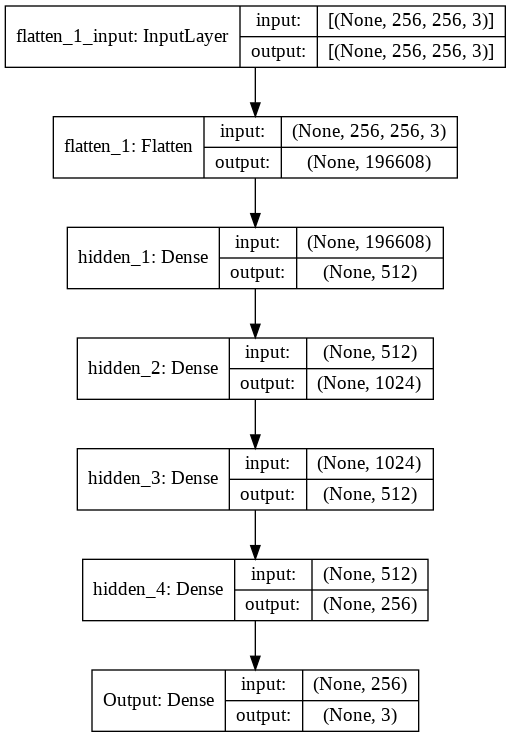

In [ ]:
plot_model(model_fc_3, show_shapes = True, show_layer_names = True)

In [ ]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate, staircase = True)
optimizer = Adam(learning_rate = schedule)

metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_fc_3, optimizer, metric, metric_val, epochs+1)


epoch 1/101
3108/3108 [==============================] - 91s 29ms/step - acc: 0.6651 - loss: 364.1155

epoch 1/101
388/388 [==============================] - 7s 18ms/step - val_acc: 0.7965 - val_loss: 19.1083
Accuracy over epoch 1 = 0.6740669 and Val_Accuracy = 0.8041237
loss over epoch 1 = 364.11554 and val_loss = 19.108253

epoch 2/101
3108/3108 [==============================] - 91s 29ms/step - acc: 0.7274 - loss: 125.4938

epoch 2/101
388/388 [==============================] - 7s 18ms/step - val_acc: 0.7871 - val_loss: 11.7084
Accuracy over epoch 2 = 0.7274775 and Val_Accuracy = 0.80927837
loss over epoch 2 = 125.4938 and val_loss = 11.708374

epoch 3/101
3108/3108 [==============================] - 90s 29ms/step - acc: 0.7562 - loss: 76.4389

epoch 3/101
388/388 [==============================] - 7s 18ms/step - val_acc: 0.8352 - val_loss: 9.7723
Accuracy over epoch 3 = 0.77380955 and Val_Accuracy = 0.83762884
loss over epoch 3 = 76.43889 and val_loss = 9.772272

epoch 4/101
3108/

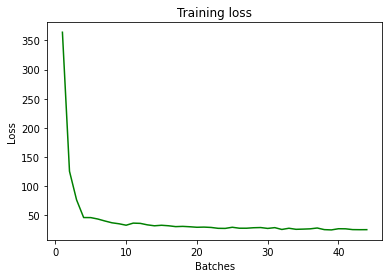

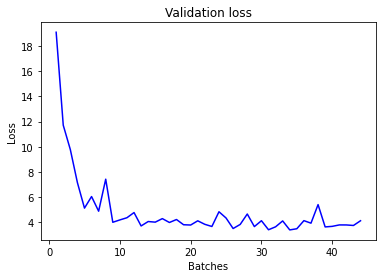

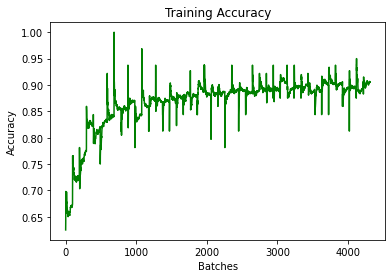

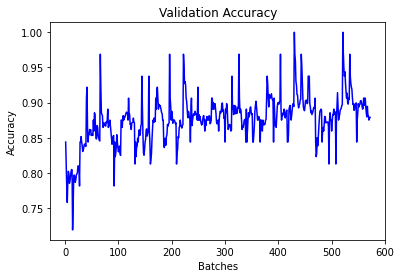

In [ ]:
plotVisuals(train_loss, val_loss, train_accuracy, val_accuracy)

390/390 [==============================] - 8s 21ms/step - acc: 0.9126 - loss: 7.4688
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       120
           1       0.85      0.85      0.85       135
           2       0.83      0.85      0.84       135

    accuracy                           0.88       390
   macro avg       0.89      0.88      0.89       390
weighted avg       0.88      0.88      0.88       390



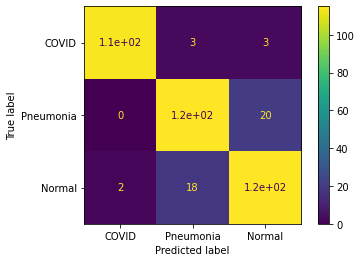

In [ ]:
metric = CategoricalAccuracy(name = "Accuracy")
report, confusion_mat = evaluate(model_fc_3, metric)
print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

# 1.2. Deep-Fully Connected Network Model

In [ ]:
model_fc_10 = Sequential([
    Flatten(input_shape = (256, 256, 3), name = "flatten_1"),
    Dense(512, 'relu', name = "hidden_1"),
    Dense(512, 'relu', name = "hidden_2"),
    Dense(1024, 'relu', name = "hidden_3"),
    Dense(1024, 'relu', name = "hidden_4"),
    Dense(1024, 'relu', name = "hidden_5"),
    Dense(512, 'relu', name = "hidden_6"),
    Dense(512, 'relu', name = "hidden_7"),
    Dense(256, 'relu', name = "hidden_8"),
    Dense(128, 'relu', name = "hidden_9"),
    Dense(3, 'softmax', name = "Output")], 
    name = "DeepFullyConnected")


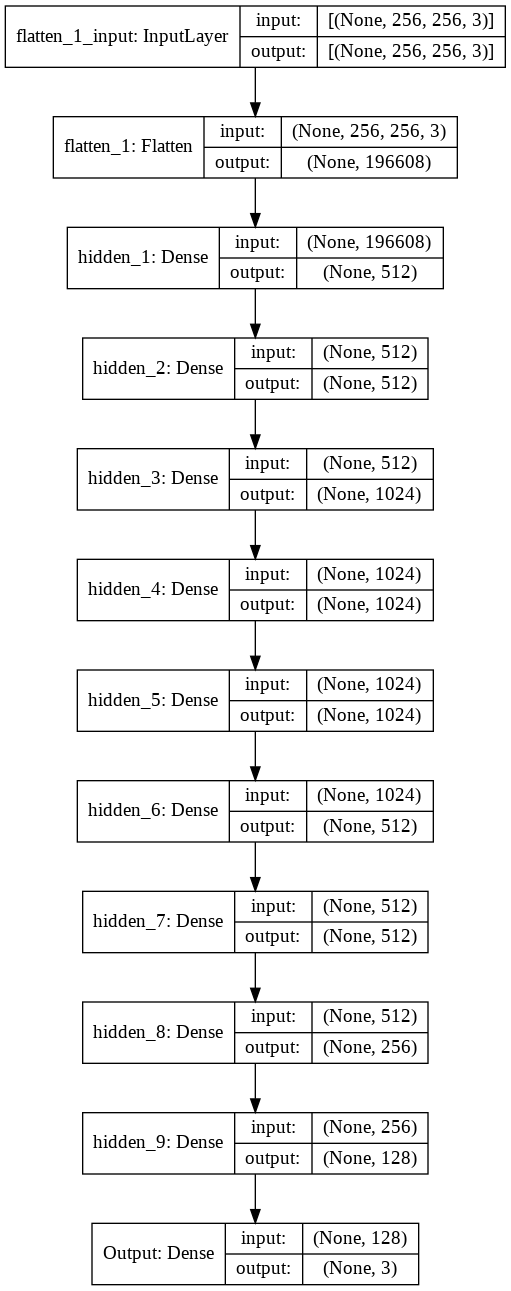

In [ ]:
plot_model(model_fc_10, show_shapes = True, show_layer_names = True)

In [ ]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate, staircase = True)
optimizer = Adam(learning_rate = schedule)

metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_fc_10, optimizer, metric, metric_val, epochs+2)


epoch 1/102
3108/3108 [==============================] - 90s 29ms/step - acc: 0.5288 - loss: 176.0794

epoch 1/102
388/388 [==============================] - 7s 18ms/step - val_acc: 0.8266 - val_loss: 7.1544
Accuracy over epoch 1 = 0.63642216 and Val_Accuracy = 0.82474226
loss over epoch 1 = 176.07936 and val_loss = 7.154421

epoch 2/102
3108/3108 [==============================] - 91s 29ms/step - acc: 0.7650 - loss: 57.1518

epoch 2/102
388/388 [==============================] - 7s 18ms/step - val_acc: 0.8180 - val_loss: 6.4379
Accuracy over epoch 2 = 0.77380955 and Val_Accuracy = 0.80927837
loss over epoch 2 = 57.151775 and val_loss = 6.4378734

epoch 3/102
3108/3108 [==============================] - 90s 29ms/step - acc: 0.7893 - loss: 51.7214

epoch 3/102
388/388 [==============================] - 7s 18ms/step - val_acc: 0.8841 - val_loss: 5.1879
Accuracy over epoch 3 = 0.795045 and Val_Accuracy = 0.8556701
loss over epoch 3 = 51.721386 and val_loss = 5.1878786

epoch 4/102
3108/3

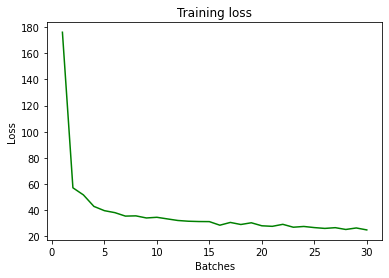

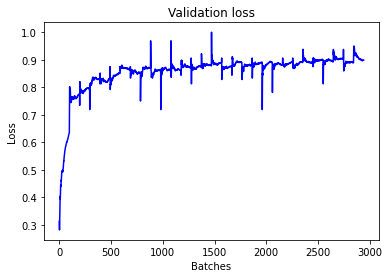

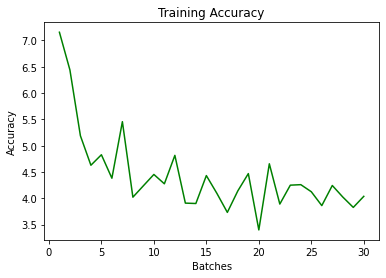

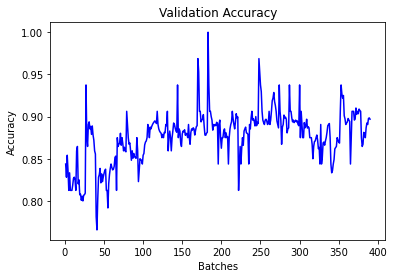

In [ ]:
plotVisuals(train_loss, train_accuracy, val_loss, val_accuracy)

390/390 [==============================] - 8s 20ms/step - acc: 0.9425 - loss: 6.9701
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       120
           1       0.85      0.87      0.86       135
           2       0.86      0.84      0.85       135

    accuracy                           0.89       390
   macro avg       0.90      0.90      0.90       390
weighted avg       0.89      0.89      0.89       390



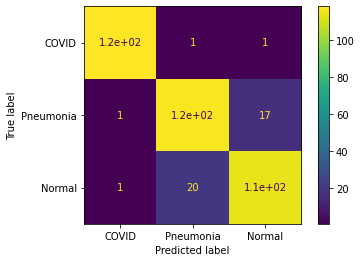

In [ ]:
metric = CategoricalAccuracy(name = "Accuracy")
report, confusion_mat = evaluate(model_fc_10, metric)
print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

# 2.1. Shallow-Convolutional Network Model

In [ ]:
model_conv = Sequential([
    Conv2D(6, (5, 5), input_shape = (256, 256, 3), activation = "relu", strides = 1, name = "convolutional_1"), 
    AveragePooling2D((5, 5), strides = 2, name = "AveragePooling_1"),
    Conv2D(6, (5, 5), activation = "relu", strides = 1, name = "convolutional_2"), 
    AveragePooling2D((5, 5), strides = 2, name = "AveragePooling_2"),
    GlobalAveragePooling2D(name = "GlobalAveragePooling_1"),
    Dense(120, "relu", name = "hidden_1"),
    Dense(84, "relu", name = "hidden_2"),
    Dense(3, "softmax", name = "output")], 
    name = "ShallowConvolutional")


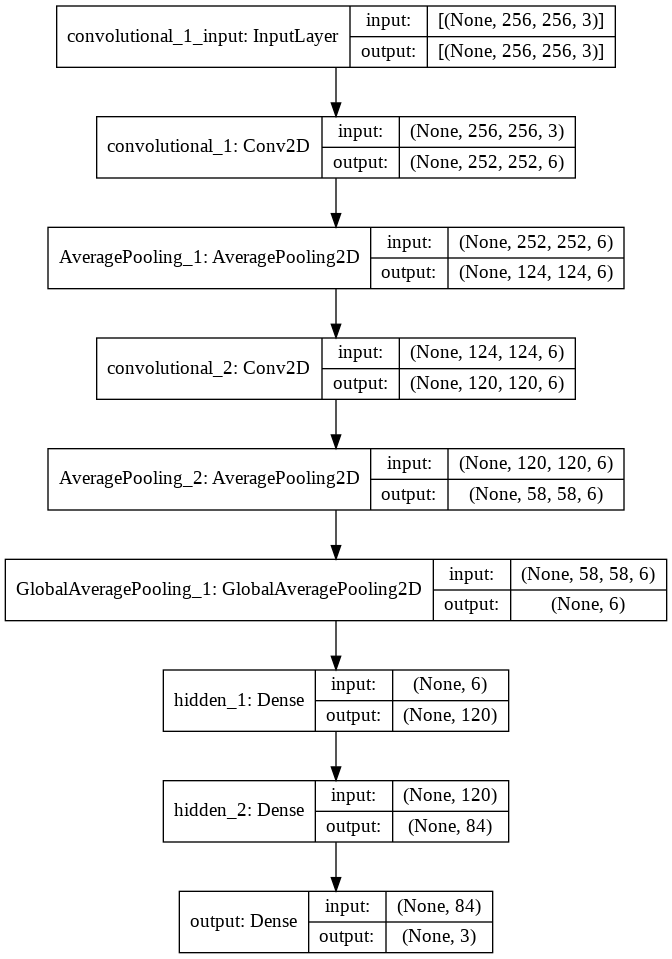

In [ ]:
plot_model(model_conv, show_shapes = True, show_layer_names = True)

In [ ]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate, staircase = True)
optimizer = Adam(learning_rate=schedule)

metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_conv, optimizer, metric, metric_val, epochs+3)


epoch 1/103
3108/3108 [==============================] - 96s 31ms/step - acc: 0.3396 - loss: 106.7489

epoch 1/103
388/388 [==============================] - 7s 18ms/step - val_acc: 0.4429 - val_loss: 13.5012
Accuracy over epoch 1 = 0.3671171 and Val_Accuracy = 0.46391752
loss over epoch 1 = 106.74895 and val_loss = 13.501246

epoch 2/103
3108/3108 [==============================] - 89s 29ms/step - acc: 0.5080 - loss: 93.6726

epoch 2/103
388/388 [==============================] - 7s 18ms/step - val_acc: 0.6835 - val_loss: 10.0119
Accuracy over epoch 2 = 0.54375803 and Val_Accuracy = 0.71649486
loss over epoch 2 = 93.67259 and val_loss = 10.011915

epoch 3/103
3108/3108 [==============================] - 91s 29ms/step - acc: 0.6418 - loss: 76.9232

epoch 3/103
388/388 [==============================] - 7s 18ms/step - val_acc: 0.6916 - val_loss: 9.0764
Accuracy over epoch 3 = 0.65894467 and Val_Accuracy = 0.693299
loss over epoch 3 = 76.923225 and val_loss = 9.076436

epoch 4/103
3108/

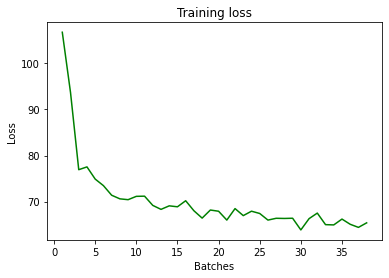

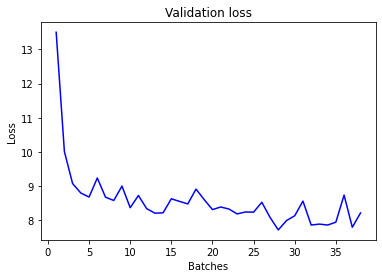

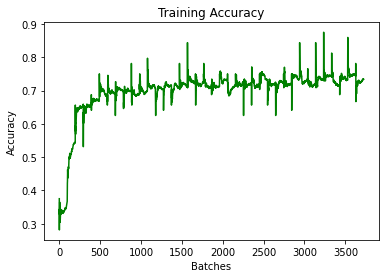

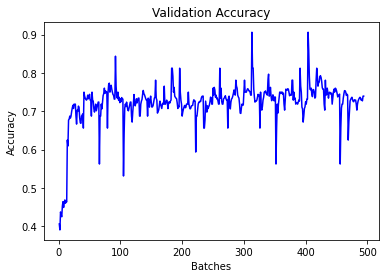

In [ ]:
plotVisuals(train_loss, val_loss, train_accuracy, val_accuracy)

390/390 [==============================] - 8s 21ms/step - acc: 0.7468 - loss: 17.4736
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       120
           1       0.70      0.91      0.79       135
           2       0.68      0.53      0.60       135

    accuracy                           0.72       390
   macro avg       0.72      0.71      0.71       390
weighted avg       0.72      0.72      0.71       390



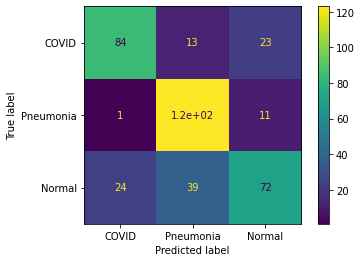

In [ ]:
metric = CategoricalAccuracy(name = "Accuracy")

report, confusion_mat = evaluate(model_conv, metric)

print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

# 2.2. Deep-Convolutional Network Model

In [ ]:
model_conv_deep = Sequential([
    Conv2D(64, (3, 3), input_shape = (256, 256, 3), activation = "relu", strides = 1, name = "convolutional_1"), 
    MaxPool2D((2, 2), strides = 2, name = "MaxPooling_1"),
    Conv2D(128, (3, 3), activation = "relu", strides = 1, name = "convolutional_2"), 
    MaxPool2D((2, 2), strides = 2, name = "MaxPooling_2"),
    Conv2D(256, (3, 3), activation = "relu", strides = 1, name = "convolutional_3"), 
    MaxPool2D((2, 2), strides = 2, name = "MaxPooling_3"),
    Conv2D(512, (3, 3), activation = "relu", strides = 1, name = "convolutional_4"), 
    MaxPool2D((2, 2), strides = 2, name = "MaxPooling_4"),
    Conv2D(512, (3, 3), activation = "relu", strides = 1, name = "convolutional_5"), 
    MaxPool2D((2, 2), strides = 2, name = "MaxPooling_5"),
    GlobalAveragePooling2D(name = "GlobalAveragePooling_1"), 
    Dense(4096, "relu", name = "hidden_1"),
    Dense(4096, "relu", name = "hidden_2"),
    Dense(1000, "relu", name = "hidden_3"),
    Dense(3, "softmax", name = "output")],
    name = "DeepConvolutional")


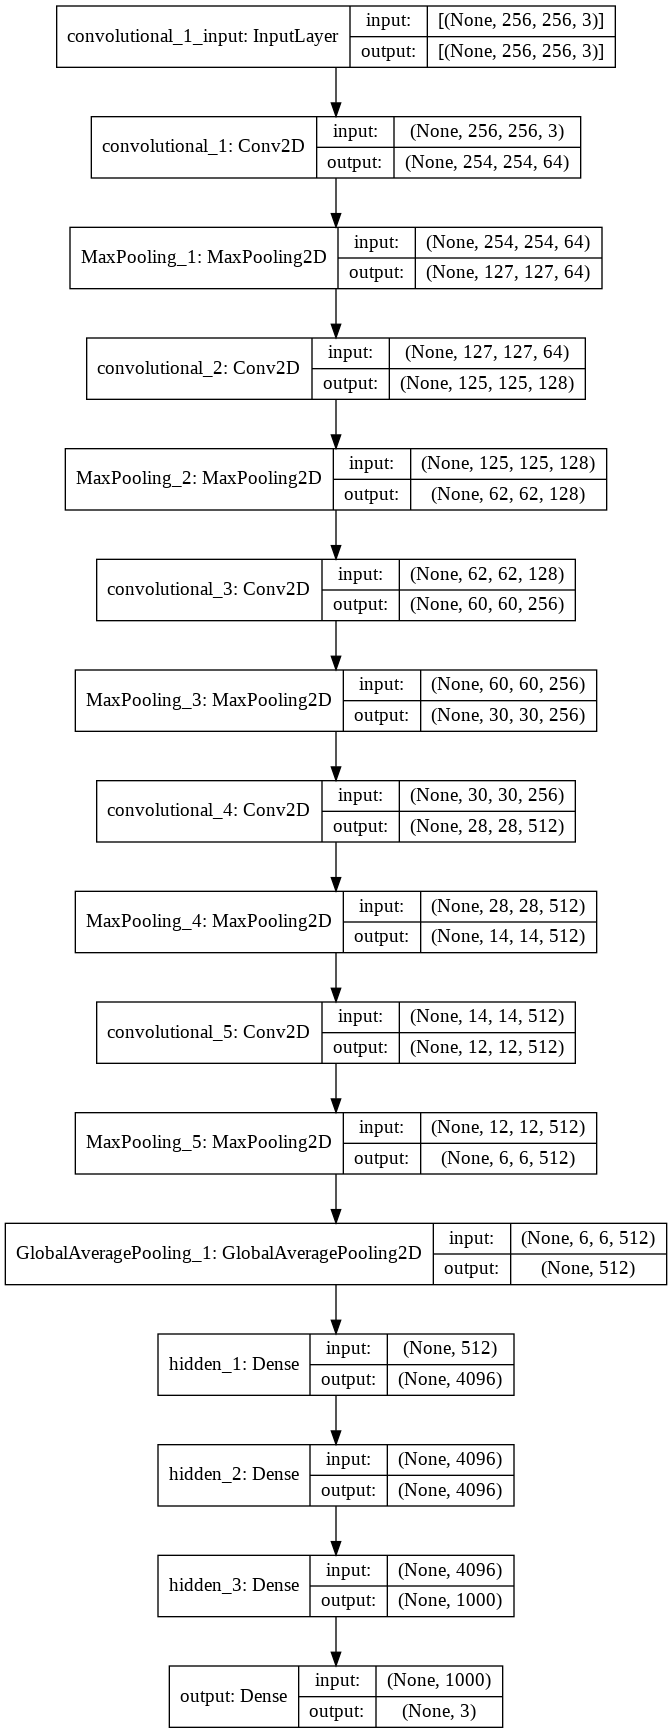

In [ ]:
plot_model(model_conv_deep, show_shapes = True, show_layer_names = True)

In [ ]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate,staircase=True)
optimizer = Adam(learning_rate = schedule)

metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_conv_deep, optimizer, metric, metric_val, epochs+4)


epoch 1/104
3108/3108 [==============================] - 118s 38ms/step - acc: 0.3580 - loss: 105.1971

epoch 1/104
388/388 [==============================] - 8s 20ms/step - val_acc: 0.6159 - val_loss: 10.2603
Accuracy over epoch 1 = 0.39736164 and Val_Accuracy = 0.6056701
loss over epoch 1 = 105.19708 and val_loss = 10.260289

epoch 2/104
3108/3108 [==============================] - 113s 36ms/step - acc: 0.5615 - loss: 80.6532

epoch 2/104
388/388 [==============================] - 8s 20ms/step - val_acc: 0.7388 - val_loss: 7.8462
Accuracy over epoch 2 = 0.60971683 and Val_Accuracy = 0.7474227
loss over epoch 2 = 80.65319 and val_loss = 7.8462224

epoch 3/104
3108/3108 [==============================] - 114s 37ms/step - acc: 0.6832 - loss: 60.6626

epoch 3/104
388/388 [==============================] - 8s 20ms/step - val_acc: 0.8112 - val_loss: 6.7664
Accuracy over epoch 3 = 0.7351995 and Val_Accuracy = 0.83247423
loss over epoch 3 = 60.662617 and val_loss = 6.766419

epoch 4/104
310

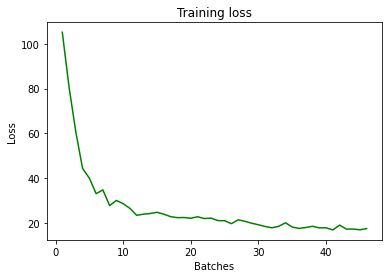

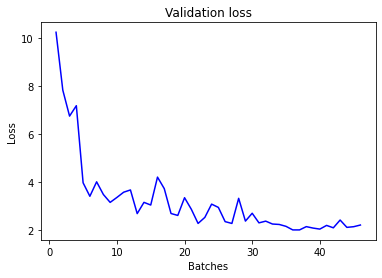

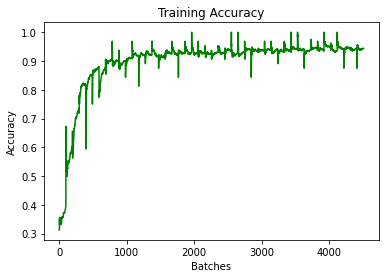

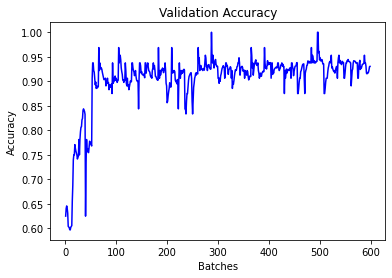

In [ ]:
plotVisuals(train_loss, val_loss, train_accuracy, val_accuracy)

390/390 [==============================] - 10s 27ms/step - acc: 0.9449 - loss: 5.5667
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       120
           1       0.88      0.89      0.88       135
           2       0.89      0.87      0.88       135

    accuracy                           0.91       390
   macro avg       0.91      0.91      0.91       390
weighted avg       0.91      0.91      0.91       390



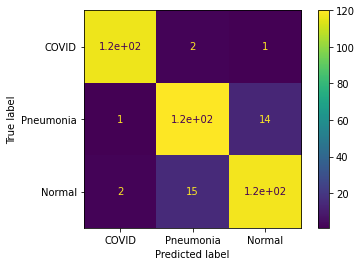

In [ ]:
last_layer_names_conv_deep = [
    'GlobalAveragePooling_1',
    
    'output'
]
last_conv_layer_conv_deep = 'convolutional_5'
report, confusion_mat = evaluate(model_conv_deep, metric)
print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

# 3.1. ResNet50 Model

In [ ]:
model_resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = (256, 256, 3))
model_resnet50.trainable = False

x = model_resnet50.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3, 'softmax', name = "Output")(x)

model_resnet50 = Model(inputs = model_resnet50.input, outputs = y_hat, name = "ResNet50")


94773248/94765736 [==============================] - 0s 0us/step


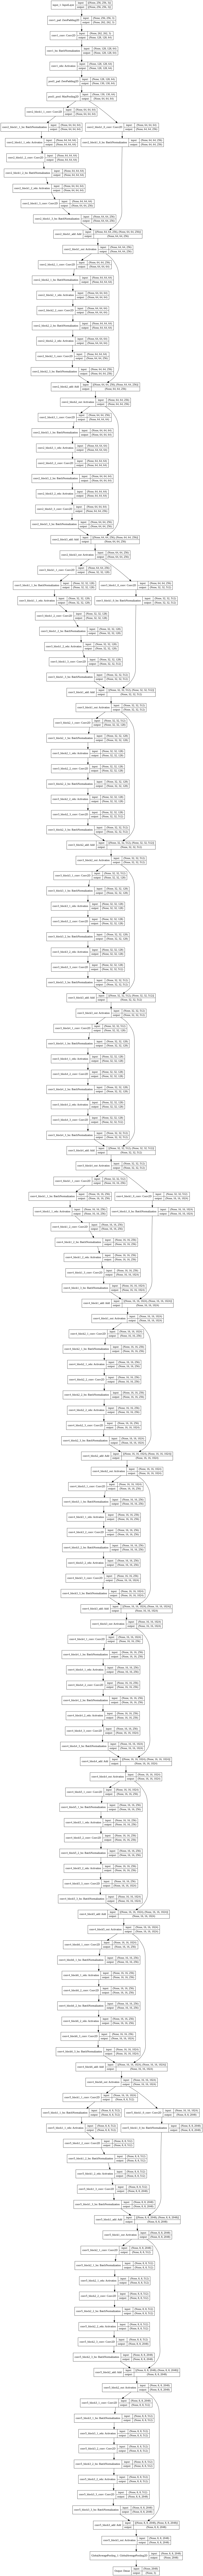

In [ ]:
plot_model(model_resnet50, show_shapes = True, show_layer_names = True)

In [ ]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate,staircase=True)
optimizer = Adam(learning_rate = schedule)
metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_resnet50, optimizer, metric, metric_val, epochs+5)


epoch 1/105
3108/3108 [==============================] - 127s 41ms/step - acc: 0.6023 - loss: 72.2794

epoch 1/105
388/388 [==============================] - 9s 22ms/step - val_acc: 0.7799 - val_loss: 7.6070
Accuracy over epoch 1 = 0.67760617 and Val_Accuracy = 0.76804125
loss over epoch 1 = 72.27944 and val_loss = 7.6070366

epoch 2/105
3108/3108 [==============================] - 126s 41ms/step - acc: 0.8175 - loss: 53.4915

epoch 2/105
388/388 [==============================] - 8s 22ms/step - val_acc: 0.8144 - val_loss: 7.9522
Accuracy over epoch 2 = 0.80534106 and Val_Accuracy = 0.7886598
loss over epoch 2 = 53.491478 and val_loss = 7.9521556

epoch 3/105
3108/3108 [==============================] - 127s 41ms/step - acc: 0.8120 - loss: 49.4226

epoch 3/105
388/388 [==============================] - 9s 22ms/step - val_acc: 0.8331 - val_loss: 5.6197
Accuracy over epoch 3 = 0.8146718 and Val_Accuracy = 0.83505154
loss over epoch 3 = 49.42261 and val_loss = 5.619686

epoch 4/105
3108/

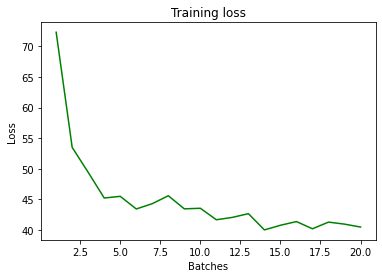

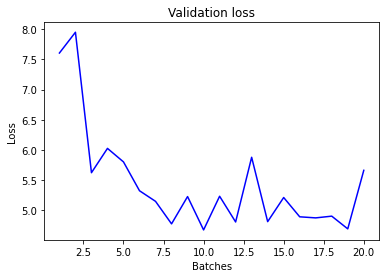

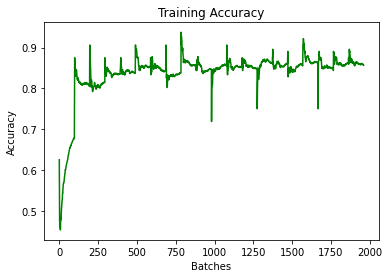

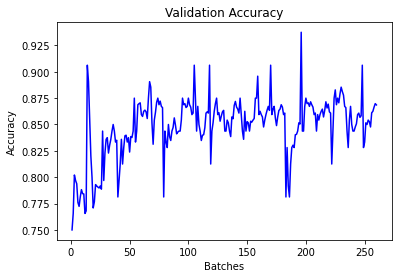

In [ ]:
plotVisuals(train_loss, val_loss, train_accuracy, val_accuracy)

390/390 [==============================] - 12s 31ms/step - acc: 0.8726 - loss: 11.3088
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       120
           1       0.79      0.95      0.86       135
           2       0.87      0.80      0.83       135

    accuracy                           0.86       390
   macro avg       0.87      0.86      0.86       390
weighted avg       0.87      0.86      0.86       390



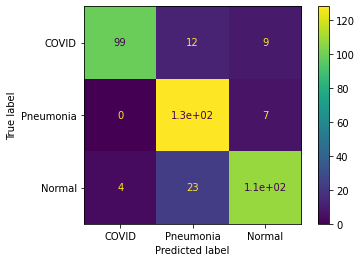

In [ ]:
metric = CategoricalAccuracy(name = "Accuracy")
last_layer_names_res = [
    'GlobalAveragePooling_1',
    
    'Output'
]
last_conv_layer_res = 'conv5_block3_out'
report, confusion_mat = evaluate(model_resnet50, metric)

print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

# 3.2. DenseNet121 Model

In [57]:
model_DenseNet121 = DenseNet121(include_top = False, weights = "imagenet", input_shape = (256, 256, 3))
model_DenseNet121.trainable = False

x = model_DenseNet121.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)
y_hat = Dense(3, 'softmax', name = "Output")(x)

model_DenseNet121 = Model(inputs = model_DenseNet121.input, outputs = y_hat, name = "DenseNet121")

In [ ]:
plot_model(model_DenseNet121, show_shapes = True, show_layer_names = True)

In [ ]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate,staircase=True)
optimizer = Adam(learning_rate=schedule)
metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_DenseNet121, optimizer, metric, metric_val, epochs+6)


epoch 1/106
3108/3108 [==============================] - 129s 42ms/step - acc: 0.5744 - loss: 66.3161

epoch 1/106
388/388 [==============================] - 9s 22ms/step - val_acc: 0.7812 - val_loss: 5.9676
Accuracy over epoch 1 = 0.7149292 and Val_Accuracy = 0.7938144
loss over epoch 1 = 66.31615 and val_loss = 5.967633

epoch 2/106
3108/3108 [==============================] - 130s 42ms/step - acc: 0.8455 - loss: 38.5513

epoch 2/106
388/388 [==============================] - 9s 23ms/step - val_acc: 0.8602 - val_loss: 5.3654
Accuracy over epoch 2 = 0.8603604 and Val_Accuracy = 0.87886596
loss over epoch 2 = 38.551346 and val_loss = 5.3654175

epoch 3/106
3108/3108 [==============================] - 130s 42ms/step - acc: 0.8843 - loss: 30.2063

epoch 3/106
388/388 [==============================] - 9s 22ms/step - val_acc: 0.9126 - val_loss: 3.7223
Accuracy over epoch 3 = 0.89157015 and Val_Accuracy = 0.92268044
loss over epoch 3 = 30.206259 and val_loss = 3.7222848

epoch 4/106
3108/

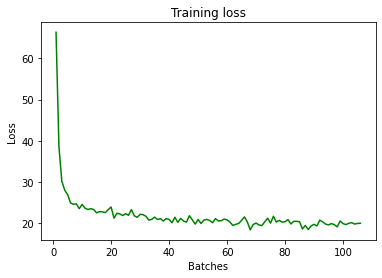

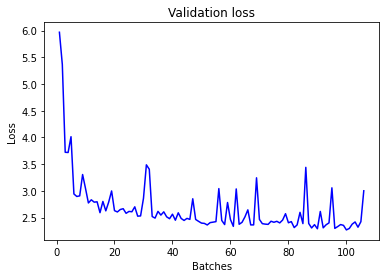

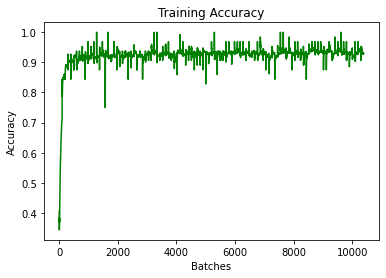

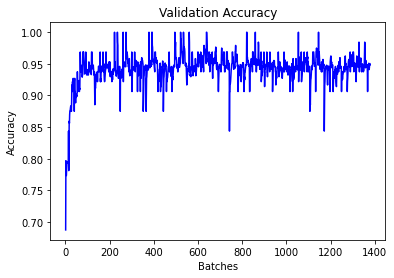

In [ ]:
plotVisuals(train_loss, val_loss, train_accuracy, val_accuracy)

390/390 [==============================] - 12s 30ms/step - acc: 0.9618 - loss: 5.5421
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       120
           1       0.84      0.99      0.90       135
           2       0.97      0.82      0.89       135

    accuracy                           0.92       390
   macro avg       0.93      0.92      0.93       390
weighted avg       0.93      0.92      0.92       390



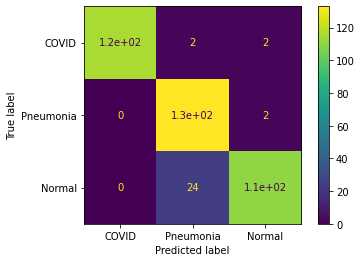

In [62]:
heatmaps_array=[]
metric = CategoricalAccuracy(name = "Accuracy")
last_layer_names = [
    'GlobalAveragePooling_1' ,
    'Output'
]
last_conv_layer = 'conv5_block16_concat'
report,confusion_mat = evaluate(model_DenseNet121, metric)

print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

# 3.3 InceptionV3 Model

In [ ]:
model_InceptionV3 = InceptionV3(include_top = False, weights = "imagenet", input_shape = (256, 256, 3))
model_InceptionV3.trainable = False

x = model_InceptionV3.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)


y_hat = Dense(3,'softmax', name = "Output")(x)

model_InceptionV3 = Model(inputs = model_InceptionV3.input, outputs = y_hat)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
plot_model(model_InceptionV3, show_shapes = True, show_layer_names = True)

In [46]:
decay_step = 250.0
initial_learning_rate = 0.001
decay_rate = 2.0
schedule = InverseTimeDecay(initial_learning_rate, decay_step, decay_rate, staircase = True)
optimizer = Adam(learning_rate = schedule)

metric = CategoricalAccuracy(name = "Accuracy")
metric_val = CategoricalAccuracy(name = "Val_Accuracy")

train_loss, train_accuracy, val_loss, val_accuracy = train(model_InceptionV3, optimizer, metric, metric_val, epochs+7)


epoch 1/107
3108/3108 [==============================] - 121s 39ms/step - acc: 0.4986 - loss: 84.3738

epoch 1/107
388/388 [==============================] - 8s 21ms/step - val_acc: 0.8217 - val_loss: 6.5437
Accuracy over epoch 1 = 0.6023166 and Val_Accuracy = 0.83505154
loss over epoch 1 = 84.37385 and val_loss = 6.5436807

epoch 2/107
3108/3108 [==============================] - 119s 38ms/step - acc: 0.7426 - loss: 63.1833

epoch 2/107
388/388 [==============================] - 8s 21ms/step - val_acc: 0.8296 - val_loss: 5.7637
Accuracy over epoch 2 = 0.7477477 and Val_Accuracy = 0.8479381
loss over epoch 2 = 63.183308 and val_loss = 5.7637296

epoch 3/107
3108/3108 [==============================] - 118s 38ms/step - acc: 0.7586 - loss: 58.5865

epoch 3/107
388/388 [==============================] - 8s 21ms/step - val_acc: 0.8548 - val_loss: 4.8992
Accuracy over epoch 3 = 0.75611323 and Val_Accuracy = 0.8685567
loss over epoch 3 = 58.58648 and val_loss = 4.8991585

epoch 4/107
3108/3

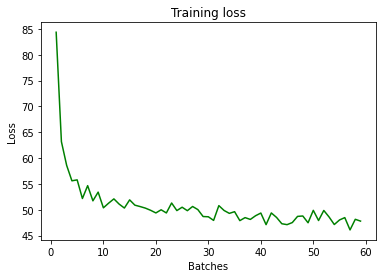

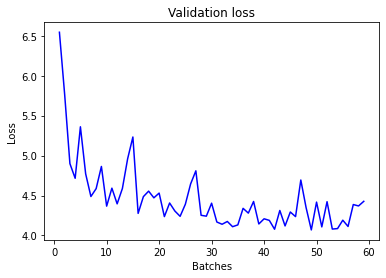

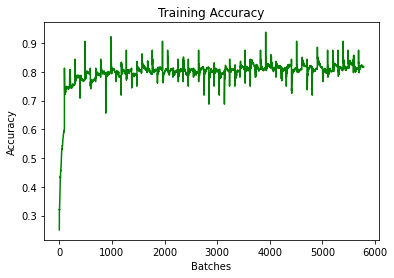

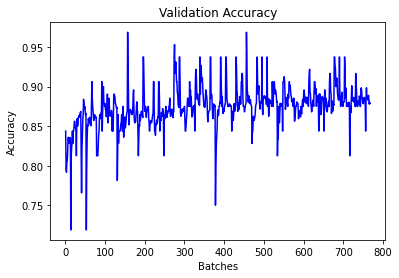

In [47]:
plotVisuals(train_loss, val_loss, train_accuracy, val_accuracy)

390/390 [==============================] - 13s 32ms/step - acc: 0.8561 - loss: 9.6566
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       120
           1       0.79      0.87      0.83       135
           2       0.82      0.83      0.82       135

    accuracy                           0.85       390
   macro avg       0.87      0.85      0.86       390
weighted avg       0.86      0.85      0.86       390



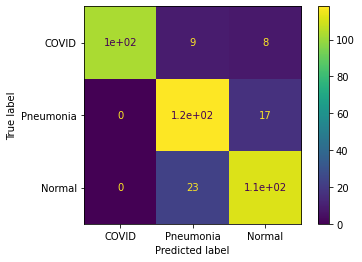

In [48]:
metric = CategoricalAccuracy(name = "Accuracy")
last_layer_names_inc = [
    'GlobalAveragePooling_1',
  
    'Output'
]
last_conv_layer_inc = 'mixed10'
report, confusion_mat = evaluate(model_InceptionV3, metric)

print(report)
ConfusionMatrixDisplay(confusion_matrix = confusion_mat,display_labels=['COVID','Pneumonia','Normal']).plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


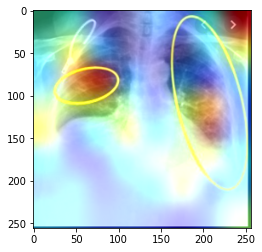

In [60]:
img=getImage(path="/content/test_5.PNG")

heatmaps_t=make_gradcam_heatmap(img[:,:,:-1], model_DenseNet121, last_conv_layer_name=last_conv_layer, classifier_layer_names=last_layer_names)
ims=overlay_heatmaps(heatmaps_t,img[:,:,:-1])
plt.imshow(ims[0])